In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import itertools as it
from collections import Counter, defaultdict, deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from toolz.curried import get, curry, compose

# Define environment

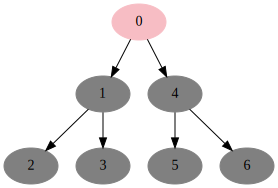

In [2]:
from distributions import Normal
import distributions
from mouselab import MouselabEnv
from exact import solve

def make_env():
    reward = Normal(3, 6).to_discrete(6).apply(compose(int, round))
    return MouselabEnv.new_symmetric([2,2], reward, cost=1)

env = make_env()
env.render()

# Optimal policy

Because we can compute the true optimal Q function, we can implement the optimal policy
as a `SoftmaxPolicy` using `Q` as a preference function, and a very low temperature.

In [3]:
from policies import SoftmaxPolicy
Q, V, *_ = solve(env)
V(env.init)
optimal_policy = SoftmaxPolicy(Q)

## Simulate rollouts

Running rollouts of the optimal policy on 200 randomly selected environments.

In [4]:
from agents import run_episode

def simulate(policy, envs, seed=None, repeat=1):
    if seed is None:
        seed = np.random.randint(1e5)
    np.random.seed(seed)
    for env_id, env in envs.items():
        for _ in range(repeat):
            trace = run_episode(policy, env)
            for s, a, r in zip(*get(['states', 'actions', 'rewards'], trace)):
                yield {'seed': seed, 'cost': abs(env.cost), 'env_id': env_id,
                       'state': s, 'action': a, 'reward': r}

envs = Series([make_env() for _ in range(200)])
df_optimal = DataFrame(simulate(optimal_policy, envs))

## View rollouts

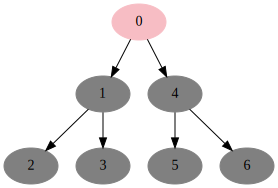

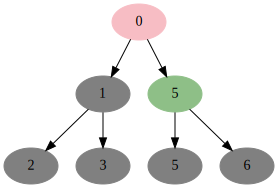

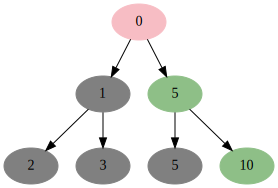

In [5]:
from IPython.display import display
def render(trace):
    for i, (s, a, r) in enumerate(zip(*get(['states', 'actions', 'rewards'], trace))):
        env._state = s
        dot = env.render()
        display(dot)

from agents import run_episode
trace = run_episode(optimal_policy, env)
render(trace)

## Model

`SoftMaxPolicy` selects actions by sampling from action probabilities generated by its
`action_distribution` method. We can use that method as a likelihood model as well.
I print summary statistics to get an idea of the fit quality. "Predictive power" (a name I made up)
is very similar to _perplexity_, but it's in probability units.

In [6]:
def policy_model(policy, data):
    return data.apply(lambda row: policy.action_distribution(row.state)[row.action], axis=1)

logp_optimal = np.log(policy_model(optimal_policy, df_optimal))
print('Probabilities of optimal policy actions under the optimal model')
print(np.exp(logp_optimal).value_counts().sort_index())
print(f'\nPredictive power: {np.exp(logp_optimal.mean()):.3f}', )

Probabilities of optimal policy actions under the optimal model
0.333333      5
0.333333     16
0.333334     10
0.500000      1
0.500000    461
0.500000      4
1.000000    419
dtype: int64

Predictive power: 0.677


# Random Policy

Now we can do the same thing again (without redefining functions) for the random policy.
Note that the random policy is uniform oveer *legal* actions only. As we would hope, it
less predictive of itself compared to the optimal policy.

In [7]:
from mouselab_policy import MouselabPolicy
rand_policy = MouselabPolicy({'term_reward': 0})
# NOTE: must run one episode before calling for action_distribution
run_episode(rand_policy, env)
env.reset()
env.step(2)
print(env._state)
print(rand_policy.action_distribution(env._state))

(0, Cat, 1, Cat, Cat, Cat, Cat)
[0.    0.167 0.    0.167 0.167 0.167 0.167 0.167]


In [8]:
df = DataFrame(simulate(rand_policy, envs))
logp_rand = np.log(policy_model(rand_policy, df))
print('Probabilities of random policy actions under the random model')
print(np.exp(logp_rand).value_counts().sort_index())
print(f'\nPredictive power: {np.exp(logp_rand.mean()):.3f}', )

Probabilities of random policy actions under the random model
0.142857    200
0.166667    171
0.200000    142
0.250000    107
0.333333     83
0.500000     57
1.000000     39
dtype: int64

Predictive power: 0.222


In [9]:
def observed(state, node):
    return not hasattr(state[node], 'sample')

# Best first

This is just a start, not sure it's correct.

In [ ]:
def softmax_logp(prefs, temp, actions):
    idx = np.arange(len(actions))
    ep = np.exp(prefs / temp)
    return np.log(ep[idx, actions] / ep.sum(1))

In [ ]:
pref_logp = softmax_logp(prefs, temp, actions)
pref_logp


In [ ]:
def etr(state):
    

In [4]:
def model(states, actions):
    pruning_logp = ...
    satisficing_logp = ...
    forwards_logp = ...
    backwards_logp = ...
    
    strategy_prefs = ...
    

    

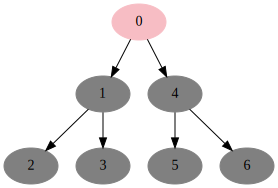

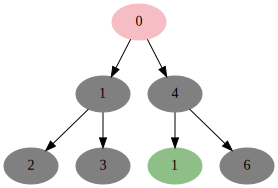

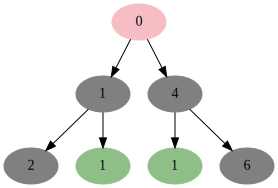

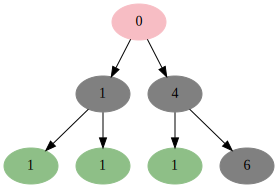

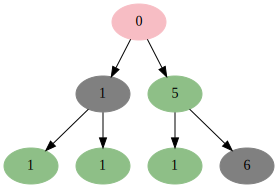

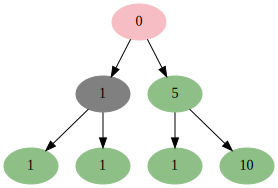

In [10]:
def best_first_pref(state, action, satisfice=9):
    if action == env.term_action:
        if env.expected_term_reward(state) > satisfice:
            return 1e10  # always terminate
        else:
            return -1e10  # never terminate (unless it's the only option)
    q = env.node_quality(action, state)  # note backwards arguments!  plz don't ask why...
    return q.expectation()  # node_quality is a distribution, we just want the mean

best_first_policy = SoftmaxPolicy(best_first_pref)
bf_trace = run_episode(best_first_policy, env)
render(bf_trace)

In [11]:
df = DataFrame(simulate(best_first_policy, envs))
logp_best_first = np.log(policy_model(best_first_policy, df))
print('Probabilities of best_firstom policy actions under the best_firstom model')
print(np.exp(logp_best_first).value_counts().sort_index())
print(f'\nPredictive power: {np.exp(logp_best_first.mean()):.3f}', )

Probabilities of best_firstom policy actions under the best_firstom model
0.166667    200
0.200000     63
0.250000     18
0.333333     81
0.500000    101
1.000000    343
dtype: int64

Predictive power: 0.450


## Breadth First

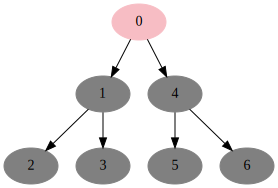

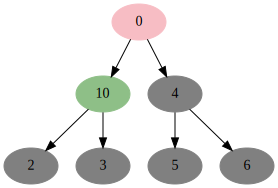

In [12]:
def breadth_first_pref(state, action, satisfice=9):
    if action == env.term_action: #not too sure about this, ask Fred
        if env.expected_term_reward(state) > satisfice:
            return 1e10  # always terminate
        else:
            return -1e10  # never terminate (unless it's the only option)
    previous_nodes = env.path_to(action)[:-1]
    if not all(observed(state, node) for node in previous_nodes):
        return -1e10
    
    return -len(previous_nodes)  # Prefer nodes that are closer to the start

breadth_first_policy = SoftmaxPolicy(breadth_first_pref)
bdf_trace = run_episode(breadth_first_policy, env)
render(bdf_trace)

In [13]:
df = DataFrame(simulate(breadth_first_policy, envs))
logp_breadth_first = np.log(policy_model(breadth_first_policy, df))
print('Probabilities of breadth_first policy actions under the breadth_first model')
print(np.exp(logp_breadth_first).value_counts().sort_index())
print(f'\nPredictive power: {np.exp(logp_breadth_first.mean()):.3f}', )

Probabilities of breadth_first policy actions under the breadth_first model
0.250000    123
0.333333     85
0.500000    262
1.000000    404
dtype: int64

Predictive power: 0.601


## Depth First

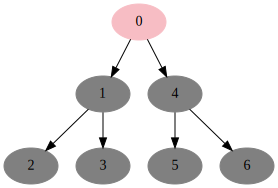

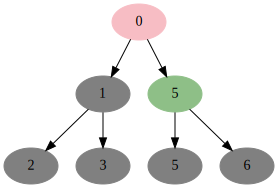

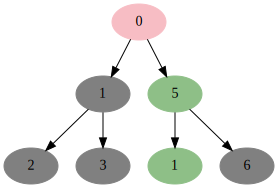

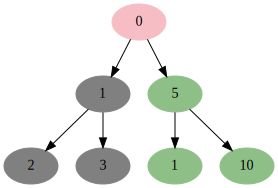

In [14]:
def depth_first_pref(state, action, satisfice=9):
    if action == env.term_action:
        if env.expected_term_reward(state) > satisfice:
            return 1e10  # always terminate
        else:
            return -1e10  # never terminate (unless it's the only option)
    # Don't click nodes not on the frontier.
    previous_nodes = env.path_to(action)[:-1]
    if not all(observed(state, node) for node in previous_nodes):
        return -1e10
  # Prefer nodes that are further from the start
    return len(previous_nodes)


depth_first_policy = SoftmaxPolicy(depth_first_pref)
df_trace = run_episode(depth_first_policy, env)
render(df_trace)

In [15]:
df = DataFrame(simulate(depth_first_policy, envs))
logp_depth_first = np.log(policy_model(depth_first_policy, df))
print('Probabilities of depth_first policy actions under the depth_first model')
print(np.exp(logp_depth_first).value_counts().sort_index())
print(f'\nPredictive power: {np.exp(logp_depth_first.mean()):.3f}', )

Probabilities of depth_first policy actions under the depth_first model
0.5    428
1.0    455
dtype: int64

Predictive power: 0.715


## Backwards Best

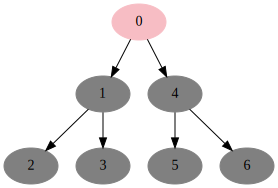

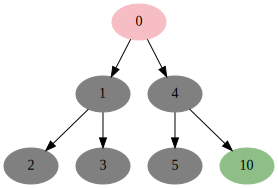

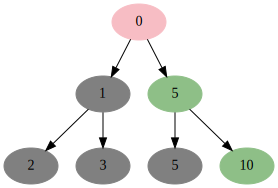

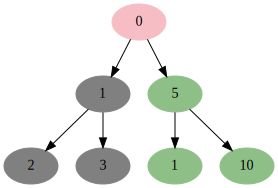

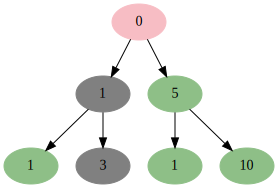

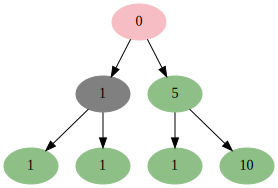

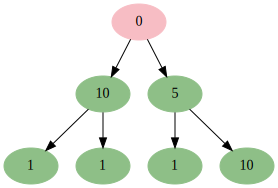

In [16]:
def backwards_best_pref(state, action, satisfice=15, goal=0):
    if action == env.term_action:
        if env.expected_term_reward(state) > satisfice:
            return 1e10  # always terminate
        else:
            return -1e10  # never terminate (unless it's the only option)
    previous_nodes = env.path_to(action)[:-1]
    v = env.node_quality(action, state).expectation()
    q = max(0, v) + len(previous_nodes) #should be biased towards farther away nodes
    return q
    
backwards_best_policy = SoftmaxPolicy(backwards_best_pref)
bb_trace = run_episode(backwards_best_policy, env)
render(bb_trace)

In [17]:
df = DataFrame(simulate(backwards_best_policy, envs))
logp_bb = np.log(policy_model(backwards_best_policy, df))
print('Probabilities of backwards_best policy actions under the backwards_best model')
print(np.exp(logp_bb).value_counts().sort_index())
print(f'\nPredictive power: {np.exp(logp_bb.mean()):.3f}', )

Probabilities of backwards_best policy actions under the backwards_best model
0.250000    200
0.333333    109
0.500000    159
1.000000    760
dtype: int64

Predictive power: 0.662
